In [86]:
#
#  Fetching data from travelweekly to be used to help train model.
#
# >>> travelweekly.get_hotel('The Nobu Palo Alto')
# {'travelweekly_year_built': 2013, 'travelweekly_num_floors': 8, 'travelweekly_num_rooms': 73, 'travelweekly_chain': 'Nobu Hotels', 'travelweekly_events_num_rooms': 6, 'travelweekly_events_total_sqft': 3000}
#

from bs4 import BeautifulSoup
import requests
import json
import re

def get_hotel(hotel_name):
    try:
      url = 'https://www.travelweekly.com/AutoComplete.asmx/GetCompleteList'
      headers = {
          'content-type': 'application/json; charset=UTF-8',
          'origin': 'https://www.travelweekly.com',
          'referer': 'https://www.travelweekly.com/Hotels/Destinations,United-States',
          'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36'
      }
      data = json.dumps({"Request": {"Term": hotel_name.split(', an')[0], "Context": "HOT"}}).encode('utf-8')
      response = requests.post(url, headers=headers, data=data)
      for res in response.json()['d']:
          if res['Type'] == 'HOT' and res['URL'] != None:
              r = requests.get(f"https://www.travelweekly.com{res['URL']}", headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36'})
              return extract_hotel_info(r.text)
      return {}
    except:
      return {}

def extract_hotel_info(html):
    soup = BeautifulSoup(html, 'html.parser')
    info = {}
    # 'travelweekly_year_renovated': ',
    # elif 'Year Last Renovated:' in text:
        # info['travelweekly_year_renovated'] = int(text.split('Year Last Renovated:')[1].strip().replace(',', ''))
    rooms_div = soup.find('p', class_='hotel-rooms')
    if rooms_div:
        info['travelweekly_num_rooms'] = int(rooms_div.get_text(strip=True).split('Rooms:')[1].strip().replace(',', ''))
    details_list = soup.find('div', class_='hotel-information-details')
    if details_list:
        for li in details_list.find_all('p'):
            text = li.get_text(strip=True)
            if 'Year Built:' in text:
                info['travelweekly_year_built'] = int(text.split('Year Built:')[1].strip().replace(',', ''))
            elif 'Number of Floors:' in text:
                info['travelweekly_num_floors'] = int(text.split('Number of Floors:')[1].strip().replace(',', ''))
            elif 'Chain:' in text:
                info['travelweekly_chain'] = text.split('Chain:')[1].strip()
    events_list = soup.find('div', class_='event-space row')
    if events_list:
        for p in events_list.find_all('p'):
            text = p.get_text(strip=True)
            if 'Total number of meeting rooms:' in text:
                info['travelweekly_events_num_rooms'] = int(text.split('Total number of meeting rooms:')[1].strip().replace(',', ''))
            if 'Total event space:' in text:
                info['travelweekly_events_total_sqft'] = int(text.split('Total event space:')[1].split('sq')[0].strip().replace(',', ''))
    return info


In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

basic = pd.read_csv('data/final_data.csv')
basic = basic.dropna()

In [73]:
print(len(basic), basic.columns, len(basic.columns))

2987 Index(['name', 'city', 'Width', 'Height', 'Brightness', 'Color', 'Dominate',
       'description', 'stars', 'price', 'rating', 'reviews', 'image', 'images',
       'categoryReviews', 'userReviews', 'staff', 'facilities', 'cleanliness',
       'comfort', 'valueForMoney', 'location', 'albuquerque', 'austin',
       'baltimore', 'bonston', 'calgary', 'charlotte', 'chicago', 'columbus',
       'dallas', 'denver', 'detroit', 'el_paso', 'fort_worth', 'fresno',
       'houston', 'indianapolis', 'jacksonville', 'kansas', 'las_vegas',
       'los_angeles', 'louiseville', 'memphis', 'mesa', 'milwaukee',
       'montreal', 'nashville', 'new_york', 'oklahoma_city', 'orlando',
       'philadelphia', 'phoenix', 'portland', 'sacramento', 'san_antonio',
       'san_diego', 'san_francisco', 'san_jose', 'seattle', 'toronto',
       'tucson', 'washington_dc', 'c1', 'c2', 'c3', 'd1', 'd2', 'd3'],
      dtype='object') 69


In [87]:
rows = []

for index, row in basic.iterrows():
    fetched = get_hotel(f"{row['name']} {row['city']}")
    if fetched and fetched != {}:
      rows.append(row.to_list() + list(fetched.values()))
    if index % 10 == 0:
      print(index, len(rows))

0 1
10 9
20 16
30 23
40 28
50 33
60 41
70 50
80 55
90 59
100 65
110 71
120 75
130 82
140 85
150 88
160 93
170 100
180 106
190 108
200 115
210 119
220 129
230 134
240 140
250 147
260 153
270 155
280 155
290 155
300 155
310 155
320 155
330 155
340 156
350 156
360 156
370 156
380 156
390 156
400 156
410 156
420 156
430 156
440 156
450 156
460 158
470 158
480 158
490 159
500 159
510 160
520 161
530 170
540 178
550 188
560 195
570 199
580 199
590 199
600 199
610 199
620 199
630 199
640 200
650 200
660 200
670 208
680 217
690 223
700 230
710 236
720 242
730 249
740 258
750 266
760 270
770 274
780 283
790 291
800 301
810 309
820 314
830 320
840 326
850 334
860 341
870 347
880 351
890 355
900 358
910 362
920 365
930 371
940 372
950 373
960 374
970 374
980 382
990 389
1000 396
1010 401
1020 407
1030 408
1040 408
1050 408
1060 409
1070 409
1080 409
1090 409
1100 410
1110 410
1120 411
1130 411
1140 412
1150 412
1160 413
1170 413
1180 413
1190 413
1200 413
1210 415
1220 415
1230 415
1240 419
1250 

In [89]:
df = pd.DataFrame(rows, columns=['name', 'city', 'Width', 'Height', 'Brightness', 'Color', 'Dominate',
       'description', 'stars', 'price', 'rating', 'reviews', 'image', 'images',
       'categoryReviews', 'userReviews', 'staff', 'facilities', 'cleanliness',
       'comfort', 'valueForMoney', 'location', 'albuquerque', 'austin',
       'baltimore', 'bonston', 'calgary', 'charlotte', 'chicago', 'columbus',
       'dallas', 'denver', 'detroit', 'el_paso', 'fort_worth', 'fresno',
       'houston', 'indianapolis', 'jacksonville', 'kansas', 'las_vegas',
       'los_angeles', 'louiseville', 'memphis', 'mesa', 'milwaukee',
       'montreal', 'nashville', 'new_york', 'oklahoma_city', 'orlando',
       'philadelphia', 'phoenix', 'portland', 'sacramento', 'san_antonio',
       'san_diego', 'san_francisco', 'san_jose', 'seattle', 'toronto',
       'tucson', 'washington_dc', 'c1', 'c2', 'c3', 'd1', 'd2', 'd3', 'travelweekly_year_built', 'travelweekly_num_floors', 'travelweekly_num_rooms', 'travelweekly_chain', 'travelweekly_events_num_rooms', 'travelweekly_events_total_sqft']).select_dtypes(['number'])
print(df.columns)

Index(['Width', 'Height', 'Brightness', 'stars', 'price', 'rating', 'reviews',
       'staff', 'facilities', 'cleanliness', 'comfort', 'valueForMoney',
       'location', 'albuquerque', 'austin', 'baltimore', 'bonston', 'calgary',
       'charlotte', 'chicago', 'columbus', 'dallas', 'denver', 'detroit',
       'el_paso', 'fort_worth', 'fresno', 'houston', 'indianapolis',
       'jacksonville', 'kansas', 'las_vegas', 'los_angeles', 'louiseville',
       'memphis', 'mesa', 'milwaukee', 'montreal', 'nashville', 'new_york',
       'oklahoma_city', 'orlando', 'philadelphia', 'phoenix', 'portland',
       'sacramento', 'san_antonio', 'san_diego', 'san_francisco', 'san_jose',
       'seattle', 'toronto', 'tucson', 'washington_dc', 'c1', 'c2', 'c3', 'd1',
       'd2', 'd3', 'travelweekly_year_built', 'travelweekly_num_floors',
       'travelweekly_events_num_rooms', 'travelweekly_events_total_sqft'],
      dtype='object')


In [101]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb

X, y = df.drop('price', axis=1), df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=False)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=False)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:46:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE of the base model: 0.295


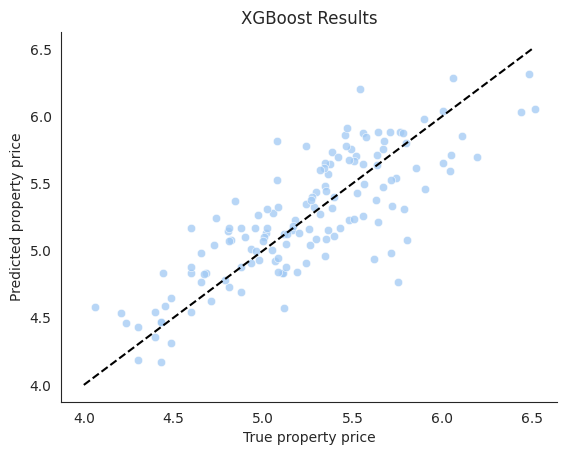

In [105]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

predicted = model.predict(dtest_reg)
rmse = mean_squared_error(y_test, predicted, squared=False)
print(f"RMSE of the base model: {rmse:.3f}", )

sns.scatterplot(x=y_test, y=predicted, alpha=0.75)
x_range = np.linspace(4, 6.5, 10)
sns.lineplot(x=x_range, y=x_range, color='k', ls="--")
plt.xlabel("True property price")
plt.ylabel("Predicted property price")
plt.title("XGBoost Results")
sns.despine()
plt.show()